In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
df_task = pd.read_csv("Data/Parker/parker new nback 1_27.11.20_18.01.15.md.bp.csv", skiprows=1)
df_control = pd.read_csv("Data/Parker/parker control 2_25.11.20_19.19.36.md.pm.bp.csv", skiprows=1)
df_task.dropna(subset=["POW.AF4.Alpha"], inplace=True)
df_control.dropna(subset=["POW.AF4.Alpha"], inplace=True)

In [3]:
df_task.head()

,Timestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,...,POW.F8.Theta,POW.F8.Alpha,POW.F8.BetaL,POW.F8.BetaH,POW.F8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma
12,1.606522e+09,118.0,0.0,4224.358887,4229.487305,4238.974121,4330.897461,4571.282227,4219.743652,4238.333496,...,13.917477,4.983940,2.082821,1.696961,2.023704,13.223186,4.987593,1.908210,1.068960,1.465190
28,1.606522e+09,6.0,0.0,4118.205078,4243.589844,4150.897461,4611.153809,4652.692383,4141.794922,4163.717773,...,16.544249,5.049778,1.720889,1.586476,1.939206,15.908467,4.970603,1.610681,1.014201,1.342458
44,1.606522e+09,22.0,0.0,4194.358887,4466.025879,4236.666504,5103.974121,4588.974121,4204.230957,4202.307617,...,17.855951,4.932714,1.377545,1.501595,1.720720,17.724880,4.692784,1.295692,0.964463,1.168935
60,1.606522e+09,38.0,0.0,4241.025879,4592.436035,4284.230957,5118.077148,4567.051270,4256.282227,4253.205078,...,18.025751,4.876716,1.115399,1.434085,1.416041,18.545540,4.201665,1.048362,0.917509,0.966057
76,1.606522e+09,54.0,0.0,4198.461426,4523.717773,4233.461426,5019.743652,4391.025879,4222.436035,4220.128418,...,18.914663,5.332583,0.961692,1.388154,1.104800,18.921238,3.716677,0.923073,0.868960,0.770817


In [4]:
df_task = df_task.filter(regex="Timestamp|EEG.AF|EEG.F|BetaL")
df_task = df_task.filter(regex="Timestamp|EEG.AF|EEG.F|POW.F|POW.AF")
# df_task['Timestamp'] = df_task['Timestamp']-df_task['Timestamp'].iloc[0]
df_task.set_index("Timestamp", inplace=True)
df_task["Label"] = 1

df_control = df_control.filter(regex="Timestamp|EEG.AF|EEG.F|BetaL")
df_control = df_control.filter(regex="Timestamp|EEG.AF|EEG.F|POW.F|POW.AF")
# df_control['Timestamp'] = df_control['Timestamp']-df_control['Timestamp'].iloc[0]
df_control.set_index("Timestamp", inplace=True)
df_control["Label"] = 0

In [5]:
# shuffle task and no task data
df_all = pd.concat([df_task, df_control])
df_all = df_all.sample(frac=1.0)

# normalize data
df_all_data = df_all.iloc[:, :-1]
df_all_labels = df_all.iloc[:,-1:]
df_all_data = (df_all_data - df_all_data.mean()) / df_all_data.std()

# put labels back on normalized data
df_all = pd.concat([df_all_data, df_all_labels], axis=1)

# Split into train/val sets
X_train = df_all.iloc[:int(0.7*len(df_all)), :-1].to_numpy()
Y_train = df_all.iloc[:int(0.7*len(df_all)), -1].to_numpy()

X_val = df_all.iloc[int(0.7*len(df_all)):, :-1].to_numpy()
Y_val = df_all.iloc[int(0.7*len(df_all)):, -1].to_numpy()

print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

df_all.head()

(1351, 16)
(1351,)
(579, 16)
(579,)


,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4,POW.AF3.BetaL,POW.F7.BetaL,POW.F3.BetaL,POW.FC5.BetaL,POW.FC6.BetaL,POW.F4.BetaL,POW.F8.BetaL,POW.AF4.BetaL,Label
Timestamp,,,,,,,,,,,,,,,,,
1.606522e+09,0.240759,1.053487,1.183979,4.664346,0.661611,1.261243,3.096219,-0.356621,-0.093831,-0.100125,-0.081208,-0.086245,-0.087287,-0.069232,-0.101116,-0.088805,1
1.606354e+09,0.046137,0.160156,0.109718,0.034827,0.407680,0.309512,0.205861,0.223089,-0.100450,-0.110956,-0.104091,-0.106987,-0.104075,-0.113492,-0.117076,-0.100168,0
1.606522e+09,0.298682,0.073780,0.312641,0.020405,0.157462,0.063899,0.145179,0.319711,-0.103415,-0.107545,-0.102150,-0.109815,-0.111827,-0.109456,-0.115767,-0.105212,1
1.606354e+09,0.572087,0.296544,0.058995,0.325388,0.798763,-0.014251,0.525017,0.993985,-0.092337,-0.101724,-0.102217,-0.107082,-0.109259,-0.106458,-0.107633,-0.099130,0
1.606522e+09,0.094786,0.071505,0.029151,0.034105,0.257553,0.077856,0.307002,0.214868,-0.102669,-0.108974,-0.093850,-0.108456,-0.103309,-0.098695,-0.116139,-0.104284,1


In [6]:
def get_model(input_shape):
    x_input = Input(input_shape)
    x = Dense(32, activation="relu")(x_input)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=x_input, outputs=x)
    return model

In [7]:
model = get_model(X_train.shape[1]) # create an instance of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Before fitting, we have to compile the model with an optimizer (how the network adjusts the weights), loss function (what the model is
# optimized to), and any metrics we are interested in.
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [9]:
history = model.fit(x=X_train,
                    y=Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=32,
                    verbose=0, # set to 0 for no epoch updates; 1 for updates
                    epochs=100)

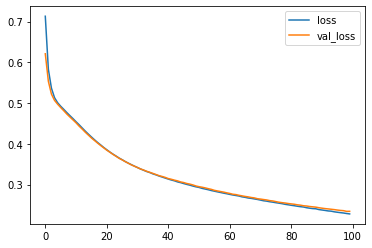

In [10]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(loss)
plt.plot(val_loss)
plt.legend(["loss","val_loss"]);